### gather and format data

In [51]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.contrib.tensor_forest.python import tensor_forest
from tensorflow.python.ops import resources
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import h5py

df = pd.read_csv('sensor_walking_5.csv')
df.columns = ['1', '2', '3', '4', 'd1', 'd2', 'd3', 'd4', 'hours', 'minutes', 'seconds']

flow = pd.read_csv('flow_walking_5.csv')
flow.columns = ['Flow']

df.head()

,1,2,3,4,d1,d2,d3,d4,hours,minutes,seconds
0,0.665746,0.726244,0.673184,0.676796,0.000000,0.000000,0.000000,0.000000,22.0,6.0,59.101363
1,0.665746,0.730769,0.673184,0.676796,0.000000,0.220961,0.000000,0.000000,22.0,6.0,59.111603
2,0.658379,0.717113,0.654562,0.662063,-0.224616,-0.410323,-0.567814,-0.449232,22.0,6.0,59.122535
3,0.646212,0.707769,0.650684,0.657308,-0.557514,-0.651668,-0.463611,-0.444241,22.0,6.0,59.133382
4,0.638701,0.704022,0.650716,0.652163,-0.615993,-0.514843,-0.286003,-0.454083,22.0,6.0,59.144207


In [52]:
flow.head()

,Flow
0,27.563000
1,18.749645
2,20.206536
3,19.119026
4,19.580812


In [53]:
def movingAvg(Class, windowSize):
    """
    Create moving average to remove single outliers

    Args:
        Class (list): List of inhale / exhale classes
        Windowsize (int): Size of moving average window

    Returns:
        filteredClass (list): Filtered list of classes
    """
    
    filteredClass = []
    for i in range(0, len(Class)):

        if i < windowSize - 1:
            filteredClass.append(Class[i])

        elif Class[i] != Class[i - 1]:
            if sum(Class[i - (windowSize - 1):(i + 1)]) / windowSize > 1:
                filteredClass.append(2)

            elif sum(Class[i - (windowSize - 1):(i + 1)]) / windowSize < 1:
                filteredClass.append(0)

            else:
                filteredClass.append(Class[i])

        elif Class[i] == Class[i - 1]:
            filteredClass.append(Class[i])
            
    return filteredClass

def classSwitch(Class):
    """
    Class switch function to filter 3 classifiers down to 2 (inhale and exhale)

    Args:
        Class (list): List of inhale / exhale classes

    Returns:
        decisionClass (list): Filtered (with moving average) of resulting simplified class
    """

    decision = []
    for i in range(0, len(Class)):
        
        if Class[i] == 1:
            decision.append(1)
            
        elif Class[i] == 0:
            decision.append(0)
            
        elif Class[i] == 2:
            if len(decision) > 1:
                decision.append(decision[-1])
            else:
                decision.append(2)
            
    return movingAvg(decision, 3)

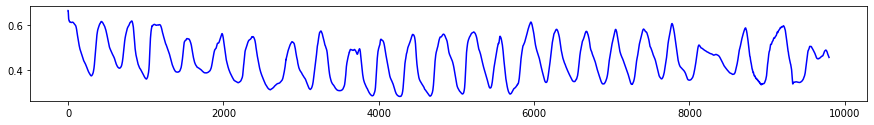

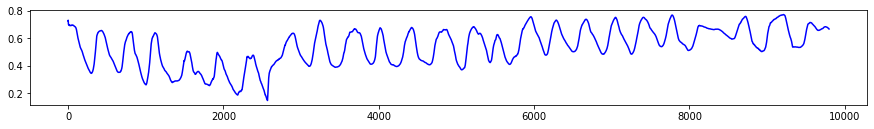

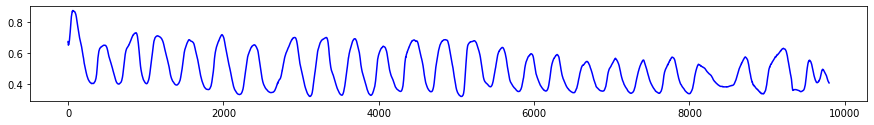

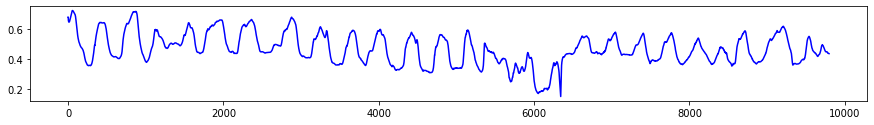

In [54]:
x = range(0, len(df))
fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,1)
plt.plot(x, df['1'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,2)
plt.plot(x, df['2'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,3)
plt.plot(x, df['3'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,4)
plt.plot(x, df['4'], 'b')
plt.show()

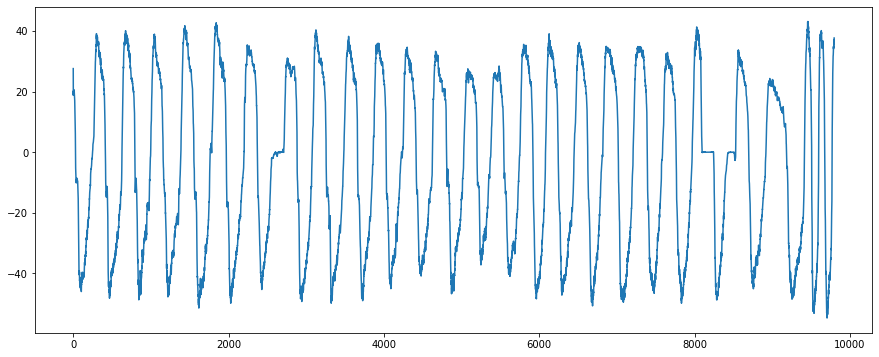

In [55]:
fig = plt.figure(figsize = (15, 6))
plt.plot(flow['Flow'])

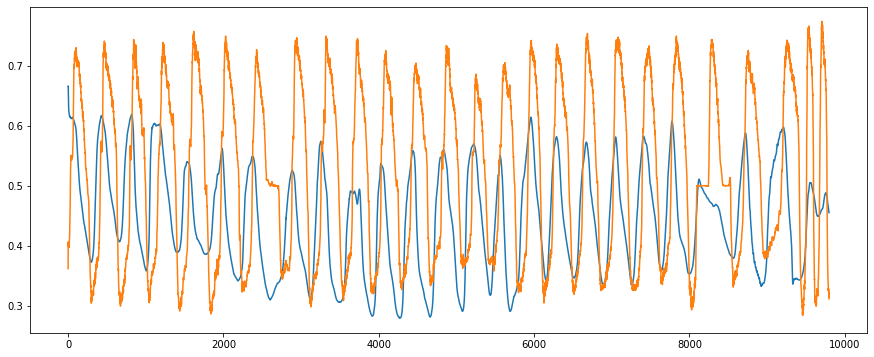

In [56]:
flow['a'] = (flow['Flow'] / 200) - 0.5
fig = plt.figure(figsize = (15, 6))
plt.plot(x, df['1'], x, flow['a']*-1)

In [57]:
flow.drop('a', inplace = True, axis = 1)

In [58]:
def label_fix(label):
    if label < -18:
        return 0
    elif label > 18:
        return 1
    else:
        return 2

df['Class'] = flow['Flow'].apply(label_fix)

In [59]:
df.head()

,1,2,3,4,d1,d2,d3,d4,hours,minutes,seconds,Class
0,0.665746,0.726244,0.673184,0.676796,0.000000,0.000000,0.000000,0.000000,22.0,6.0,59.101363,1
1,0.665746,0.730769,0.673184,0.676796,0.000000,0.220961,0.000000,0.000000,22.0,6.0,59.111603,1
2,0.658379,0.717113,0.654562,0.662063,-0.224616,-0.410323,-0.567814,-0.449232,22.0,6.0,59.122535,1
3,0.646212,0.707769,0.650684,0.657308,-0.557514,-0.651668,-0.463611,-0.444241,22.0,6.0,59.133382,1
4,0.638701,0.704022,0.650716,0.652163,-0.615993,-0.514843,-0.286003,-0.454083,22.0,6.0,59.144207,1


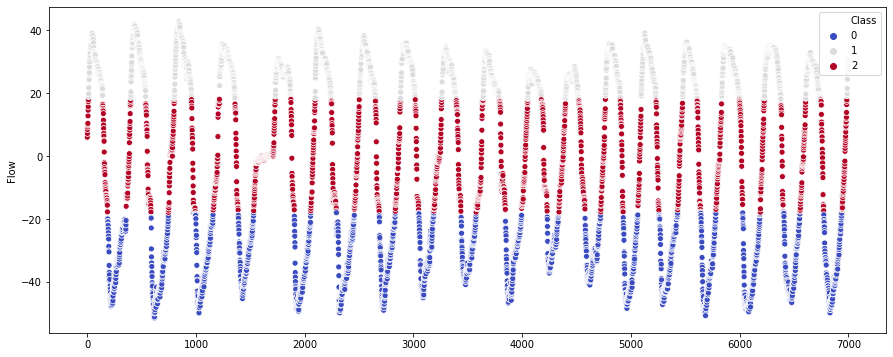

In [60]:
fig = plt.figure(figsize = (15, 6))
sns.scatterplot(y = flow['Flow'][1000:8000], x = range(0, 7000), hue = df['Class'][1000:8000], palette = 'coolwarm')

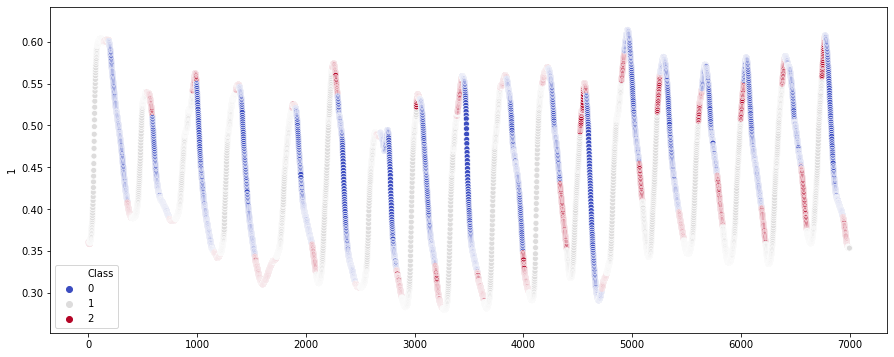

In [61]:
fig = plt.figure(figsize = (15, 6))
sns.scatterplot(y = df['1'][1000:8000], x = range(0, 7000), hue = df['Class'][1000:8000], palette = 'coolwarm')

In [62]:
df.head()

,1,2,3,4,d1,d2,d3,d4,hours,minutes,seconds,Class
0,0.665746,0.726244,0.673184,0.676796,0.000000,0.000000,0.000000,0.000000,22.0,6.0,59.101363,1
1,0.665746,0.730769,0.673184,0.676796,0.000000,0.220961,0.000000,0.000000,22.0,6.0,59.111603,1
2,0.658379,0.717113,0.654562,0.662063,-0.224616,-0.410323,-0.567814,-0.449232,22.0,6.0,59.122535,1
3,0.646212,0.707769,0.650684,0.657308,-0.557514,-0.651668,-0.463611,-0.444241,22.0,6.0,59.133382,1
4,0.638701,0.704022,0.650716,0.652163,-0.615993,-0.514843,-0.286003,-0.454083,22.0,6.0,59.144207,1


In [63]:
# Create the data matrix
X = df.drop('Class', axis = 1)
X.drop('hours', inplace = True, axis = 1)
X.drop('minutes', inplace = True, axis = 1)
X.drop('seconds', inplace = True, axis = 1)

# Create the classification matrix
y = df['Class']
y = pd.DataFrame(y, index = None, columns = ['Class'])

# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
y_test.reset_index(inplace = True, drop = True)
y_train.reset_index(inplace = True, drop = True)

In [64]:
len(X)

9799

### model training - deep learning

In [65]:
# Develop keras sequential model with optimized parameters through grid search cv
model = keras.Sequential()
model.add(keras.layers.Dense(150, activation = tf.nn.relu, input_dim = 8))
model.add(keras.layers.Dropout(0.3))
#model.add(keras.layers.Dense(125, activation = tf.nn.relu))
#model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(100, activation = tf.nn.relu))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(50, activation = tf.nn.relu))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(3, activation = tf.nn.softmax))

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 150)               1350      
_________________________________________________________________
dropout_3 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               15100     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                

In [ ]:
EPOCHS = 10000
model.fit(X_train, y_train, epochs = EPOCHS)

Epoch 1/10000
6859/6859 [==============================] - 0s 51us/sample - loss: 0.8276 - acc: 0.6166
Epoch 2/10000
6859/6859 [==============================] - 0s 33us/sample - loss: 0.6729 - acc: 0.7088
Epoch 3/10000
6859/6859 [==============================] - 0s 30us/sample - loss: 0.6206 - acc: 0.7396
Epoch 4/10000
6859/6859 [==============================] - 0s 36us/sample - loss: 0.5899 - acc: 0.7602
Epoch 5/10000
6859/6859 [==============================] - 0s 35us/sample - loss: 0.5802 - acc: 0.7641
Epoch 6/10000
6859/6859 [==============================] - 0s 43us/sample - loss: 0.5620 - acc: 0.7742
Epoch 7/10000
6859/6859 [==============================] - 0s 34us/sample - loss: 0.5367 - acc: 0.7804
Epoch 8/10000
6859/6859 [==============================] - 0s 33us/sample - loss: 0.5304 - acc: 0.7861
Epoch 9/10000
6859/6859 [==============================] - 0s 39us/sample - loss: 0.5231 - acc: 0.7873
Epoch 10/10000
6859/6859 [==============================] - 0s 48us/sampl

6859/6859 [==============================] - 0s 30us/sample - loss: 0.2527 - acc: 0.9003
Epoch 80/10000
6859/6859 [==============================] - 0s 30us/sample - loss: 0.2575 - acc: 0.8981
Epoch 81/10000
6859/6859 [==============================] - 0s 33us/sample - loss: 0.2539 - acc: 0.8955
Epoch 82/10000
6859/6859 [==============================] - 0s 32us/sample - loss: 0.2451 - acc: 0.9006
Epoch 83/10000
6859/6859 [==============================] - 0s 31us/sample - loss: 0.2429 - acc: 0.9087
Epoch 84/10000
6859/6859 [==============================] - 0s 30us/sample - loss: 0.2400 - acc: 0.9068
Epoch 85/10000
6859/6859 [==============================] - 0s 30us/sample - loss: 0.2360 - acc: 0.9058
Epoch 86/10000
6859/6859 [==============================] - 0s 30us/sample - loss: 0.2398 - acc: 0.9061
Epoch 87/10000
6859/6859 [==============================] - 0s 29us/sample - loss: 0.2370 - acc: 0.9084
Epoch 88/10000
6859/6859 [==============================] - 0s 28us/sample - lo

6859/6859 [==============================] - 0s 29us/sample - loss: 0.2056 - acc: 0.9194
Epoch 158/10000
6859/6859 [==============================] - 0s 29us/sample - loss: 0.2067 - acc: 0.9201
Epoch 159/10000
6859/6859 [==============================] - 0s 28us/sample - loss: 0.1962 - acc: 0.9220
Epoch 160/10000
6859/6859 [==============================] - 0s 29us/sample - loss: 0.2006 - acc: 0.9255
Epoch 161/10000
6859/6859 [==============================] - 0s 29us/sample - loss: 0.1893 - acc: 0.9230
Epoch 162/10000
6859/6859 [==============================] - 0s 30us/sample - loss: 0.1924 - acc: 0.9264
Epoch 163/10000
6859/6859 [==============================] - 0s 33us/sample - loss: 0.2039 - acc: 0.9205
Epoch 164/10000
6859/6859 [==============================] - 0s 32us/sample - loss: 0.2044 - acc: 0.9186
Epoch 165/10000
6859/6859 [==============================] - 0s 32us/sample - loss: 0.2089 - acc: 0.9146
Epoch 166/10000
6859/6859 [==============================] - 0s 30us/sa

6859/6859 [==============================] - 0s 28us/sample - loss: 0.1695 - acc: 0.9338
Epoch 236/10000
6859/6859 [==============================] - 0s 28us/sample - loss: 0.1742 - acc: 0.9313
Epoch 237/10000
6859/6859 [==============================] - 0s 28us/sample - loss: 0.1746 - acc: 0.9337
Epoch 238/10000
6859/6859 [==============================] - 0s 29us/sample - loss: 0.1672 - acc: 0.9392
Epoch 239/10000
6859/6859 [==============================] - 0s 29us/sample - loss: 0.1813 - acc: 0.9272
Epoch 240/10000
6859/6859 [==============================] - 0s 28us/sample - loss: 0.1648 - acc: 0.9379
Epoch 241/10000
6859/6859 [==============================] - 0s 28us/sample - loss: 0.1829 - acc: 0.9302
Epoch 242/10000
6859/6859 [==============================] - 0s 28us/sample - loss: 0.1729 - acc: 0.9340
Epoch 243/10000
6859/6859 [==============================] - 0s 30us/sample - loss: 0.1761 - acc: 0.9321
Epoch 244/10000
6859/6859 [==============================] - 0s 31us/sa

6859/6859 [==============================] - 0s 28us/sample - loss: 0.1788 - acc: 0.9335
Epoch 314/10000
6859/6859 [==============================] - 0s 27us/sample - loss: 0.1657 - acc: 0.9364
Epoch 315/10000
6859/6859 [==============================] - 0s 27us/sample - loss: 0.1735 - acc: 0.9289
Epoch 316/10000
6859/6859 [==============================] - 0s 27us/sample - loss: 0.1599 - acc: 0.9404
Epoch 317/10000
6859/6859 [==============================] - 0s 27us/sample - loss: 0.1631 - acc: 0.9370
Epoch 318/10000
6859/6859 [==============================] - 0s 29us/sample - loss: 0.1678 - acc: 0.9361
Epoch 319/10000
6859/6859 [==============================] - 0s 28us/sample - loss: 0.1733 - acc: 0.9340
Epoch 320/10000
6859/6859 [==============================] - 0s 29us/sample - loss: 0.1627 - acc: 0.9370
Epoch 321/10000
6859/6859 [==============================] - 0s 33us/sample - loss: 0.1575 - acc: 0.9375
Epoch 322/10000
6859/6859 [==============================] - 0s 30us/sa

6859/6859 [==============================] - 0s 28us/sample - loss: 0.1533 - acc: 0.9399
Epoch 392/10000
6859/6859 [==============================] - 0s 29us/sample - loss: 0.1569 - acc: 0.9386
Epoch 393/10000
6859/6859 [==============================] - 0s 30us/sample - loss: 0.1478 - acc: 0.9402
Epoch 394/10000
6859/6859 [==============================] - 0s 29us/sample - loss: 0.1534 - acc: 0.9376
Epoch 395/10000
6859/6859 [==============================] - 0s 29us/sample - loss: 0.1500 - acc: 0.9440
Epoch 396/10000
6859/6859 [==============================] - 0s 28us/sample - loss: 0.1466 - acc: 0.9396
Epoch 397/10000
6859/6859 [==============================] - 0s 28us/sample - loss: 0.1559 - acc: 0.9410
Epoch 398/10000
6859/6859 [==============================] - 0s 28us/sample - loss: 0.1554 - acc: 0.9401
Epoch 399/10000
6859/6859 [==============================] - 0s 29us/sample - loss: 0.1698 - acc: 0.9370
Epoch 400/10000
6859/6859 [==============================] - 0s 32us/sa

6859/6859 [==============================] - 0s 29us/sample - loss: 0.1532 - acc: 0.9412
Epoch 470/10000
6859/6859 [==============================] - 0s 28us/sample - loss: 0.1506 - acc: 0.9417
Epoch 471/10000
6859/6859 [==============================] - 0s 27us/sample - loss: 0.1419 - acc: 0.9455
Epoch 472/10000
6859/6859 [==============================] - 0s 27us/sample - loss: 0.1582 - acc: 0.9442
Epoch 473/10000
6859/6859 [==============================] - 0s 28us/sample - loss: 0.1546 - acc: 0.9405
Epoch 474/10000
6859/6859 [==============================] - 0s 28us/sample - loss: 0.1435 - acc: 0.9440
Epoch 475/10000
6859/6859 [==============================] - 0s 27us/sample - loss: 0.1436 - acc: 0.9443
Epoch 476/10000
6859/6859 [==============================] - 0s 27us/sample - loss: 0.1465 - acc: 0.9440
Epoch 477/10000
6859/6859 [==============================] - 0s 28us/sample - loss: 0.1579 - acc: 0.9417
Epoch 478/10000
6859/6859 [==============================] - 0s 27us/sa

6859/6859 [==============================] - 0s 29us/sample - loss: 0.1464 - acc: 0.9426
Epoch 548/10000
6859/6859 [==============================] - 0s 31us/sample - loss: 0.1544 - acc: 0.9417
Epoch 549/10000
6859/6859 [==============================] - 0s 29us/sample - loss: 0.1439 - acc: 0.9468
Epoch 550/10000
6859/6859 [==============================] - 0s 27us/sample - loss: 0.1344 - acc: 0.9507
Epoch 551/10000
6859/6859 [==============================] - 0s 28us/sample - loss: 0.1595 - acc: 0.9405
Epoch 552/10000
6859/6859 [==============================] - 0s 29us/sample - loss: 0.1359 - acc: 0.9475
Epoch 553/10000
6859/6859 [==============================] - 0s 29us/sample - loss: 0.1361 - acc: 0.9497
Epoch 554/10000
6859/6859 [==============================] - 0s 28us/sample - loss: 0.1343 - acc: 0.9494
Epoch 555/10000
6859/6859 [==============================] - 0s 31us/sample - loss: 0.1500 - acc: 0.9428
Epoch 556/10000
6859/6859 [==============================] - 0s 32us/sa

In [ ]:
# Scoring the model on testing data from same dataset
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

prediction = model.predict(X_test)

final_pred = []
for score in range(0, len(prediction)):
    final_pred.append(np.argmax(prediction[score]))
    
print(classification_report(y_test, final_pred))
print(confusion_matrix(y_test, final_pred))
Predictions = classSwitch(final_pred)
Class = classSwitch(list(y_test['Class']))
print('Keras Model')
print("\n")
print(classification_report(Class, Predictions))

In [ ]:
#export_csv = pd.DataFrame(X_test).to_csv(r'/Users/mikefurr/Documents/GitHub/coral_host/Jupyter_Notebooks/X_test.csv', header = True, index = None)

In [ ]:
#coral_results = pd.read_csv('coral_results.csv')

In [56]:
#print(classification_report(y_test, coral_results))

### model training - tensorflow random forest

### model training - random forest

In [20]:
import timeit

In [21]:
print(" Random Forest ... ")

start = timeit.default_timer()
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 5000)
rf_model = classifier.fit(X_train, y_train)
predictions = rf_model.predict(X_test)
end = timeit.default_timer()

print(" accuracy = ", accuracy_score(y_test, predictions), " time = ", end - start)
print(confusion_matrix(y_test, predictions))
print("\n")

print("Random Forest")
print(classification_report(y_test, predictions))

 Random Forest ... 


/Users/mikefurr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


 accuracy =  0.9857142857142858  time =  36.592236999999955
[[1135    0    7]
 [   0 1012   13]
 [   9   13  751]]


Random Forest
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1142
           1       0.99      0.99      0.99      1025
           2       0.97      0.97      0.97       773

    accuracy                           0.99      2940
   macro avg       0.98      0.98      0.98      2940
weighted avg       0.99      0.99      0.99      2940



In [22]:
Predictions = classSwitch(predictions)
Class = classSwitch(list(y_test['Class']))
print('Random Forest')
print("\n")
print(classification_report(Class, Predictions))

Random Forest


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2081
           1       0.99      0.98      0.98       856
           2       1.00      1.00      1.00         3

    accuracy                           0.99      2940
   macro avg       0.99      0.99      0.99      2940
weighted avg       0.99      0.99      0.99      2940



### model testing on new data

In [36]:
df_test = pd.read_csv('sensor_training_4.csv')
df_test.columns = ['1', '2', '3', '4', 'd1', 'd2', 'd3', 'd4', 'hours', 'minutes', 'seconds']

flow_test = pd.read_csv('flow_training_4.csv')
flow_test.columns = ['Flow']

In [37]:
df_test['Class'] = flow_test['Flow'].apply(label_fix)

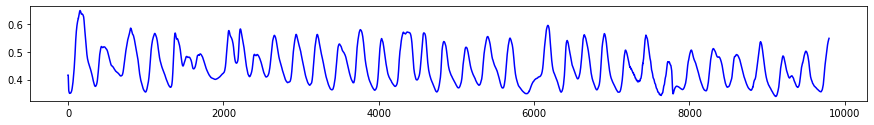

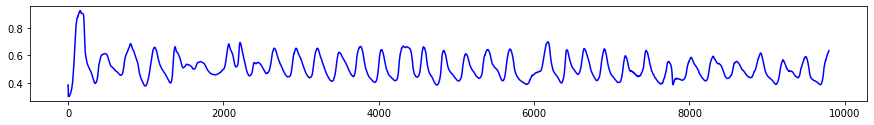

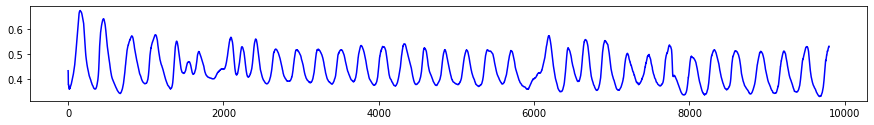

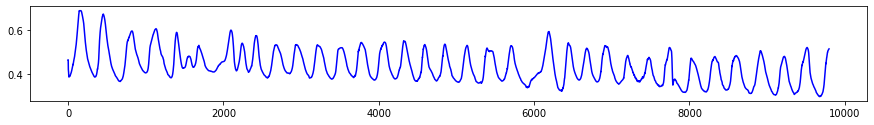

In [38]:
x = range(0, len(df_test))
fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,1)
plt.plot(x, df_test['1'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,2)
plt.plot(x, df_test['2'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,3)
plt.plot(x, df_test['3'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,4)
plt.plot(x, df_test['4'], 'b')
plt.show()

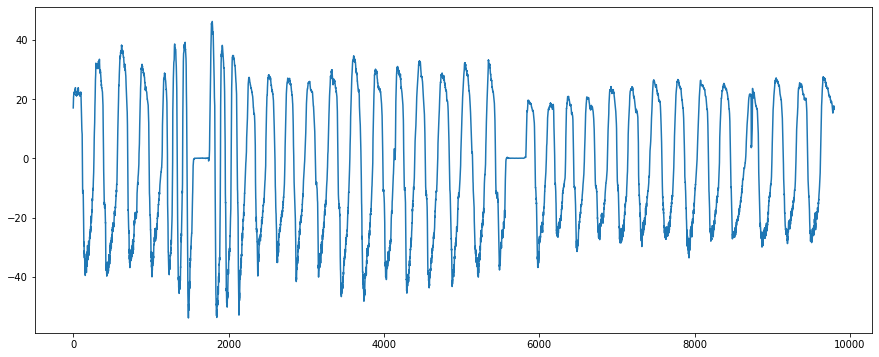

In [39]:
fig = plt.figure(figsize = (15, 6))
plt.plot(flow_test['Flow'])

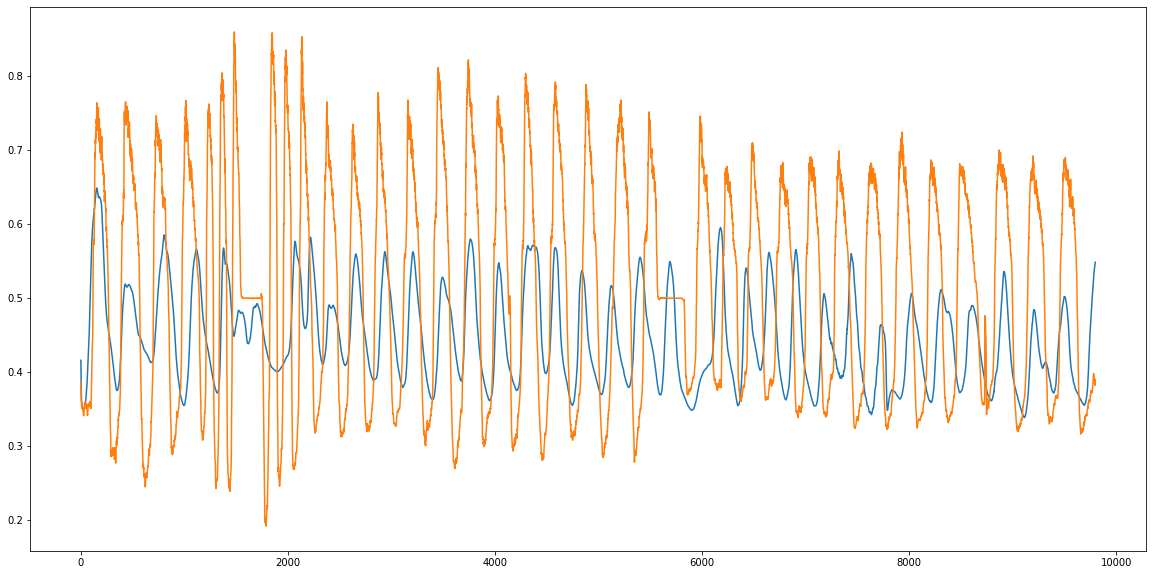

In [40]:
flow_test['a'] = (flow_test['Flow'] / 150) - 0.5
fig = plt.figure(figsize = (20, 10))
plt.plot(x, df_test['1'], x, flow_test['a']*-1)

In [41]:
flow_test.drop('a', inplace = True, axis = 1)

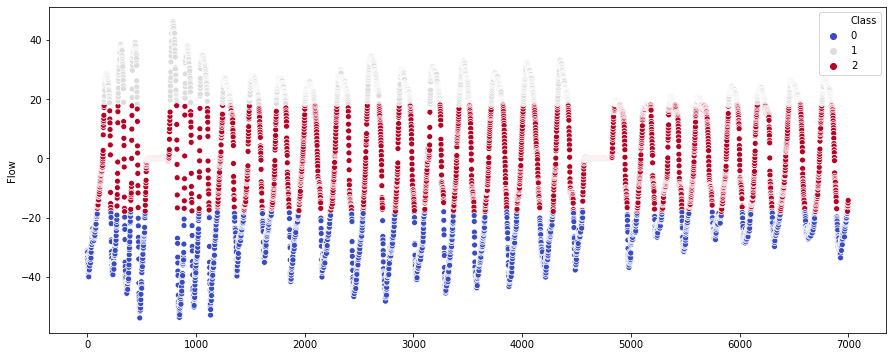

In [42]:
fig = plt.figure(figsize = (15, 6))
sns.scatterplot(y = flow_test['Flow'][1000:8000], x = range(0, 7000), hue = df_test['Class'][1000:8000], palette = 'coolwarm')

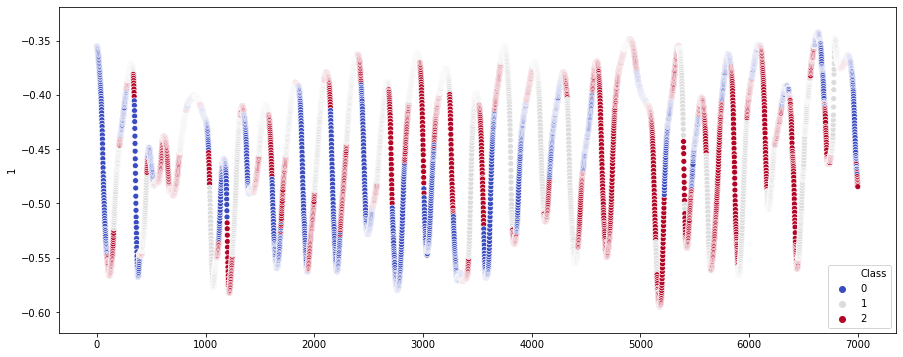

In [43]:
fig = plt.figure(figsize = (15, 6))
sns.scatterplot(y = df_test['1'][1000:8000]*-1, x = range(0, 7000), hue = df_test['Class'][1000:8000], palette = 'coolwarm')

In [44]:
test_sensors = df_test.drop('Class', axis = 1)
test_sensors.drop('hours', inplace = True, axis = 1)
test_sensors.drop('minutes', inplace = True, axis = 1)
test_sensors.drop('seconds', inplace = True, axis = 1)

# Create the classification matrix
test_class = df_test['Class']
test_class = pd.DataFrame(test_class, index = None, columns = ['Class'])

#### model testing - random forest

In [45]:
test_predictions = rf_model.predict(test_sensors)
print(" accuracy = ", accuracy_score(test_class, test_predictions))
print(confusion_matrix(test_class, test_predictions))
print("\n")

print('Random Forest - Testing')
print('\n')
print(classification_report(test_class, test_predictions))

 accuracy =  0.29360138789672413
[[1241 1657  205]
 [1379 1337  284]
 [1713 1684  299]]


Random Forest - Testing


              precision    recall  f1-score   support

           0       0.29      0.40      0.33      3103
           1       0.29      0.45      0.35      3000
           2       0.38      0.08      0.13      3696

    accuracy                           0.29      9799
   macro avg       0.32      0.31      0.27      9799
weighted avg       0.32      0.29      0.26      9799



In [46]:
testPredictions = classSwitch(test_predictions)
testClass = classSwitch(list(test_class['Class']))
print('Random Forest - Testing')
print('\n')
print(classification_report(testClass, testPredictions))

Random Forest - Testing


              precision    recall  f1-score   support

           0       0.56      0.50      0.53      5446
           1       0.45      0.51      0.48      4350
           2       0.00      0.00      0.00         3

    accuracy                           0.51      9799
   macro avg       0.34      0.34      0.34      9799
weighted avg       0.51      0.51      0.51      9799



/Users/mikefurr/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### model testing - deep learning

In [47]:
test_predictions = model.predict(test_sensors)

final_pred_test = []
for score in range(0, len(test_predictions)):
    final_pred_test.append(np.argmax(test_predictions[score]))

print('Keras Model - Testing')
print('\n')
print(classification_report(test_class, final_pred_test))

Keras Model - Testing


              precision    recall  f1-score   support

           0       0.29      0.32      0.30      3103
           1       0.30      0.52      0.38      3000
           2       0.37      0.13      0.20      3696

    accuracy                           0.31      9799
   macro avg       0.32      0.32      0.29      9799
weighted avg       0.33      0.31      0.29      9799



In [48]:
testPredictions = classSwitch(final_pred_test)
testClass = classSwitch(list(test_class['Class']))
print('Keras Model - Testing')
print('\n')
print(classification_report(testClass, testPredictions))

Keras Model - Testing


              precision    recall  f1-score   support

           0       0.56      0.42      0.48      5446
           1       0.45      0.59      0.51      4350
           2       1.00      0.33      0.50         3

    accuracy                           0.49      9799
   macro avg       0.67      0.45      0.49      9799
weighted avg       0.51      0.49      0.49      9799



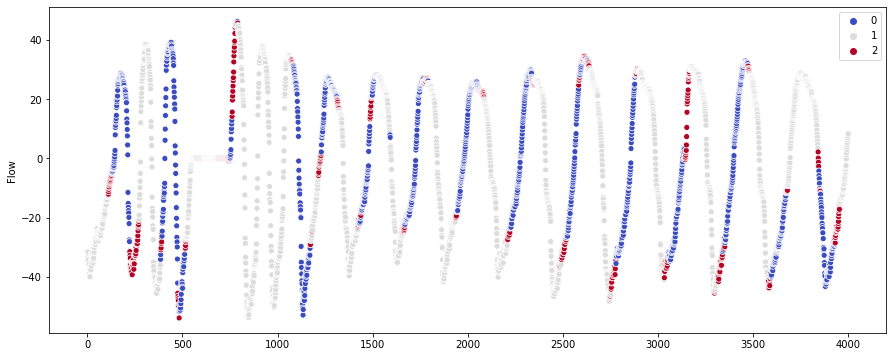

In [49]:
fig = plt.figure(figsize = (15, 6))
sns.scatterplot(y = flow_test['Flow'][1000:5000], x = range(0, 4000), hue = final_pred_test[1000:5000], palette = 'coolwarm')

In [50]:
# Looking at where either model fails
test_class['score'] = test_class['Class'] == final_pred_test
fig = plt.figure(figsize = (15, 6))
sns.scatterplot(y = flow_test['Flow'][1000:], x = range(0, 8989), hue = test_class['score'][1000:])

ValueError: array length 8989 does not match index length 8799

<Figure size 1080x432 with 0 Axes>

#### Save TFLite Model

In [75]:
keras_file = "walking_model.h5"
keras.models.save_model(model, keras_file)
converter = tf.lite.TocoConverter.from_keras_model_file('walking_model.h5')
tflite_model = converter.convert()
open("walking_model.tflite", "wb").write(tflite_model)

W1112 12:32:40.188229 4589997504 deprecation.py:323] From <ipython-input-75-6fbccb3e59ee>:3: TocoConverter.from_keras_model_file (from tensorflow.lite.python.lite) is deprecated and will be removed in a future version.
Instructions for updating:
Use `lite.TFLiteConverter.from_keras_model_file` instead.
W1112 12:32:40.192870 4589997504 deprecation.py:506] From /Users/mikefurr/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1112 12:32:40.193724 4589997504 deprecation.py:506] From /Users/mikefurr/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for

88296